In [ ]:
%matplotlib inline
import numpy
numpy.random.seed(0)

In [ ]:
def get_dataset(n=250):
    """ Creates a simple 1D dataset.
    """

    numpy.random.seed(0)
    
    X = numpy.linspace(0, 3*numpy.pi, n)
    y = 0.5 * X + numpy.random.normal(0, 0.1, n)
    
    return X, y

In [3]:
# generate a simple toy dataset with 10000 instances
# and store it on disk.
X, y = get_dataset(n=10000)
data = numpy.concatenate([y.reshape((len(y), 1)),X.reshape((len(X), 1))], axis=1)
numpy.savetxt('/home/lsda/artificial_regression.csv', data, delimiter=',')

In [7]:
class LinearLeastSquaresRegression():
    
    def __init__(self, optimizer="solve", max_iter=10, random_state=0):
        """ Instantiates the regression model.
        
        Parameters
        ----------
        optimizer : str, default 'solve'
            The optimizer to be used
        max_iter : int, default 10
            Maximum number of iterations for optimizer
        random_state : int, default 0
            The random state (seed) to be used.
        """
        
        self.optimizer = optimizer
        self.max_iter = max_iter
        self.random_state = random_state

    def get_params(self, deep=True):
        """ Returns the parameters of the model
        """
        
        return {"optimizer": self.optimizer,
                "max_iter": self.max_iter,
                "random_state": self.random_state}

    def set_params(self, **parameters):
        """ Sets the parameters of the model
        """        
        
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
            
        return self
    
    def fit(self, X, y):
        """
        Fits the regression model.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        y : Array of shape [n_samples, 1]
        """   
        
        numpy.random.seed(self.random_state)
        
        # make sure that we have numpy arrays; also
        # reshape the array X to ensure that we have
        # a multidimensional numpy array (ndarray);
        # for y, we want to have a column vector
        X = numpy.array(X).reshape((X.shape[0], -1))
        y = numpy.array(y).reshape((len(y), 1))

        self._Xtrain = X
        self._ytrain = y
        
        if self.optimizer == "solve":    
            
            G = numpy.dot(self._Xtrain.T, self._Xtrain)
            B = numpy.dot(self._Xtrain.T, self._ytrain)            
            
            self._w = numpy.linalg.solve(G, B)
            
        elif self.optimizer == "gradient":
            
            from scipy.optimize import fmin_bfgs
            
            # initial guess
            w0 = numpy.zeros(X.shape[1], dtype=numpy.float64)
            
            # additional parameters for the self._function 
            args = (self._Xtrain, self._ytrain)

            # Note that you do not necessarily have to provide fprime function, see
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html
            # (in this case, the gradient will be approximated via the function, as explrained
            # here: https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)            
            self._w = fmin_bfgs(self._function, w0, args=args, maxiter=self.max_iter, gtol=1e-10)
            
        else:
            
            raise Exception("Unknown optimizer: {}".format(self.optimizer))
            
        return self
    
    def _function(self, w, X, y):
        
        w = w.reshape((len(w),1))
        diff = y - numpy.dot(X, w)
        f = (1.0 / len(y)) * numpy.dot(diff.T, diff)
        
        return f
        
    def predict(self, X):
        """
        Computes predictions for a new set of points.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]

        Returns
        -------
        predictions : Array of shape [n_samples, 1]
        """           
        
        # make sure that we have numpy arrays; also
        # reshape the array X to ensure that we have
        # a multidimensional numpy array (ndarray)
        X = numpy.array(X).reshape((X.shape[0], -1))
            
        preds = numpy.dot(X, self._w)
                
        return preds
            

         Current function value: 0.009742
         Iterations: 2
         Function evaluations: 228
         Gradient evaluations: 72


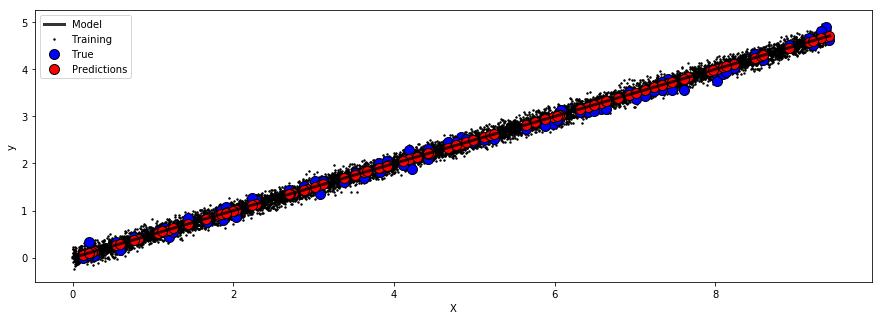

In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=1)

f, axes = plt.subplots(1, 1, sharey=True, figsize=(15,5))



model = LinearLeastSquaresRegression(optimizer="gradient", max_iter=10)
model.fit(X_train, y_train)
preds = model.predict(X_test)
    
# plot test points and predictions
axes.scatter(X_train, y_train, s=2, c="k", edgecolor="k", linewidths=1, label="Training")
axes.scatter(X_test, y_test, s=100, c="b", edgecolor="k", linewidths=1, label="True")
axes.scatter(X_test, preds, s=100, c="r", edgecolor="k", linewidths=1, label="Predictions")

# plot model
x = numpy.linspace(X.min(), X.max(), 500)
axes.plot(x, model.predict(x), "-k", alpha=0.8, linewidth=3.0, label="Model")

axes.set_xlabel("X")
axes.set_ylabel("y")
axes.legend(loc=0)
    
plt.show()

In [9]:
points_rdd = sc.textFile("file:///home/lsda/artificial_regression.csv")
points_rdd = points_rdd.repartition(4)
print("Number of RDD partitions: {}".format(points_rdd.getNumPartitions()))


Number of RDD partitions: 4


In [10]:
N = len(X_train)
D = 1

def read_points_batch(points):
    
    points = list(points)
    
    # first entry is label, the other ones the data point
    arr = numpy.zeros((len(points), D + 1))
    
    # parse the strings to data points
    for i, s in enumerate(points):
        arr[i] = numpy.fromstring(s, dtype=numpy.float32, sep=',')
    
    return [arr]

points_rdd = points_rdd.mapPartitions(read_points_batch)
points_rdd.cache()

PythonRDD[7] at RDD at PythonRDD.scala:53

In [11]:
points_rdd.take(1)

[array([[0.01911722, 0.00942572],
        [0.15061149, 0.01036829],
        [0.08175921, 0.01131086],
        ...,
        [4.76313353, 9.42289257],
        [4.70862579, 9.42383575],
        [4.84220028, 9.42477798]])]

In [ ]:
class LinearLeastSquaresRegressionSpark():
    
    def __init__(self, max_iter=10, random_state=0):
        """ Instantiates the regression model.
        
        Parameters
        ----------
        max_iter : int, default 10
            Maximum number of iterations for optimizer
        random_state : int, default 0
            The random state (seed) to be used.
        """
        
        self.max_iter = max_iter
        self.random_state = random_state

    def get_params(self, deep=True):
        """ Returns the parameters of the model
        """
        
        return {"max_iter": self.max_iter,
                "random_state": self.random_state}

    def set_params(self, **parameters):
        """ Sets the parameters of the model
        """        
        
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
            
        return self
    
    def fit(self, points, n, d):
        """
        Fits the regression model.

        Parameters
        ----------
        points : RDD
        n : Number of overall instances
        d : Dimensionality of each feature
        """   
    
        from scipy.optimize import fmin_bfgs

        # initial guess
        w0 = numpy.zeros(d, dtype=numpy.float64)
        
        # additional parameters for the _function and _function_prime
        args = (n, points)

        # Note that you do not necessarily have to provide fprime function, see
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html
        # (in this case, the gradient will be approximated via the function, as explrained
        # here: https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)
        self._w = fmin_bfgs(self._function, w0, args=args, maxiter=self.max_iter, gtol=1e-10)
            
        return self
    
    def _function(self, w, n, points):
        
        # compute the function value based on the RDD in a 
        # distributed manner via 'map' and 'reduce'.
        w = w.reshape((len(w),1))
     
        # YOUR CODE HERE
    
    def predict(self, X):
        """
        Computes predictions for a new set of points.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]

        Returns
        -------
        predictions : Array of shape [n_samples, 1]
        """           
        
        # make sure that we have numpy arrays; also
        # reshape the array X to ensure that we have
        # a multidimensional numpy array (ndarray)
        X = numpy.array(X).reshape((X.shape[0], -1))
            
        preds = numpy.dot(X, self._w)
                
        return preds
            

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=1)

f, axes = plt.subplots(1, 3, sharey=True, figsize=(15,5))



model = LinearLeastSquaresRegressionSpark(lam=lam, max_iter=10)
model.fit(points_rdd, N, D)
preds = model.predict(X_test)

# plot test points and predictions
axes.scatter(X_train, y_train, s=2, c="k", edgecolor="k", linewidths=1, label="Training")
axes.scatter(X_test, y_test, s=100, c="b", edgecolor="k", linewidths=1, label="True")
axes.scatter(X_test, preds, s=100, c="r", edgecolor="k", linewidths=1, label="Predictions")

# plot model
x = numpy.linspace(X.min(), X.max(), 500)
axes.plot(x, model.predict(x), "-k", alpha=0.8, linewidth=3.0, label="Model")

axes.set_xlabel("X")
axes.set_ylabel("y")
axes.legend(loc=0)

plt.show()